In [1]:
%matplotlib inline
# change scale of all figures to make them bigger
import matplotlib as mpl
mpl.rcParams['figure.dpi']=100 

General reminder: Anderson impurity model and CTHYB solver
=========================================

In the Anderson impurity model, we decompose the full lattice problem into an interacting site ('impurity') hybridised to a bath:

<img src="imgs/dmft_bath_impurity.png">

with the Hamiltonian
   \begin{align*}
     H = & \color{red}{H_{\rm imp}} + \color{darkgreen}{H_{\rm hyb}} + \color{blue}{H_{\rm bath}} \\
     \color{red}{H_{\rm imp}} = & \sum_{\alpha \beta} \epsilon_{\alpha \beta} c^{\dagger}_{\alpha} c_{\beta} 
     + \sum_{\alpha \beta \gamma \delta} U_{\alpha \beta \gamma \delta} c^{\dagger}_{\alpha} c^{\dagger}_{\beta} c_{\delta} c_{\gamma} \\
     \color{darkgreen}{H_{\rm hyb}} = & \sum_{\alpha \nu k} (V_{\alpha \nu k} c^{\dagger}_{\alpha} d_{\nu k} + h.~c.) \\
     \color{blue}{H_{\rm bath}} = & \sum_{\nu k} \epsilon_{\nu k} d^{\dagger}_{\nu k} d_{\nu k}.
   \end{align*}

The basic idea behind the CTHYB algorithm is to solve the impurity model by diagrammatically expanding the partition function $Z$ in orders of the hybridization function. The resulting diagrams are then sampled stochastically using Monte Carlo while measuring quantities of interest, such as the Green's function. Contrary to the IPT solver, CTHYB yields, within statistical error-bars, the **exact** solution of the impurity model.

The CTHYB solver needs two pieces of information as input from the user:
- the **interacting Hamiltonian**, $H_{\rm int} = \sum_{\alpha \beta \gamma \delta} U_{\alpha \beta \gamma \delta} c^{\dagger}_{\alpha} c^{\dagger}_{\beta} c_{\delta} c_{\gamma}$,
- the **non-interacting Green's function**, $G_0(i\omega_n)$, from which the energy levels $\epsilon$ and hybridization function are deduced.

The TRIQS/CTHYB impurity solver
===============================

In this notebook, we will see how to use the CTHYB impurity solver ([documentation here](https://triqs.github.io/cthyb/)). We will take
the example of a single-orbital Anderson impurity model with a local Coulomb interaction on
the impurity orbital

$$
H_\mathrm{int} = U n_\mathrm{\uparrow} n_\mathrm{\downarrow}
$$

The non-interacting Green's function is

$$
G_0(i\omega_n) = \frac{1}{i\omega_n - \epsilon_d - V^2 \Gamma(i\omega_n)}
$$

and $\Gamma$ is the Green's function of a flat conduction bath.

Setting up the impurity solver
------------------------------

Here is an example showing how to construct an impurity solver and run it on a single-orbital Anderson impurity model.
Wait until the calculation is over before going on (see the "Kernel busy" solid circle on the top right).

In [2]:
from triqs.gf import *
from triqs.operators import *
from triqs_cthyb import Solver

V = 1.0           # Hybridization strength
U = 4.0           # Local (on-site) Coulomb interaction
epsilon_d = 0.2   # Orbital energy level
beta = 20         # Inverse temperature

# Construct the impurity solver
S = Solver(beta = beta, gf_struct = [('up',1), ('down',1)] )

# Define the non-interacting Green's function
S.G0_iw << inverse(iOmega_n - epsilon_d - V**2 * Flat(1.0))

# Define the interacting Hamiltonian
h_int = U * n('up',0) * n('down',0)

# Solve the impurity problem for a given local Hamiltonian.
S.solve(h_int = h_int, 
        length_cycle = 10,         # Number of steps between each measurement
        n_warmup_cycles = 5000,    # Number of warmup cycles
        n_cycles = 50000           # Number of QMC cycles
       )

Starting serial run at: 2023-08-28 17:49:03.483848



╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
0.2*c_dag('down',0)*c('down',0) + 0.2*c_dag('up',0)*c('up',0) + 4*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
17:49:03 100% ETA 00:00:00 cycle 4999 of 5000



Accumulating ...
17:49:03  19% ETA 00:00:00 cycle 9760 of 50000
17:49:04 100% ETA 00:00:00 cycle 49999 of 50000


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | seconds   
Auto-correlation time | 0.00566571
Average order         | 0.000908685
Average sign          | 0.000881916
G_tau measure         | 0.0114234 
Total measure time    | 0.0188797 
[Rank 0] Acceptance rate for all moves:
Move set Insert two operators: 0.0512121
  Move  Insert Delta_up: 0.0513189
  Move  Insert Delta_down: 0.0511046
M

Let's try to explain the different lines of the script above. To construct the solver all that is needed is the inverse temperature $\beta$ and a list that describes the block structure of the Green's function. This is the `gf_struct` keyword. In this specific case, there are two (disconnected) blocks `up` and `down` and each containing only one orbital with the index 0. This is what is described by `gf_struct`.

Then, the member `S.G0_iw` of the solver is initialized. This Green's function will be used as the non-interacting Green's function when the solver starts.

The final step is to run the solver with the `solve` method. It has a certain number of parameters:

- `h_int`: This is the interacting Hamiltonian (i.e. the quartic terms in the local Hamiltonian, those with 4 operators) solved for in the Monte Carlo. It is defined using the operators that we have seen in the previous notebook. **Important**: the name of the indices in the operators have to be compatible with the `gf_struct` that was used in the construction of the solver.
- `length_cycle`: This is the number of steps at which measurements, e.g. of `G_tau`, are made to ensure data is decorrelated.
- `n_warmup_cycles`: The number of cycles used to thermalize the system.
- `n_cycles`: This is the number of Monte Carlo cycles, which is also the number of measures of the Green's function.

So a calculation will have a Markov chain of length `length_cycle` * (`n_warmup_cycles` + `n_cycles`).

When the run is over, the outputs of the solver are:

- `S.G_tau`: The Green's function in imaginary time of the system.
- `S.G_iw`: The Green's function in Matsubara frequency of the system.
- `S.Sigma_iw`: The self-energy in Matsubara frequency.

**Tips for advanced use**:
- For some more complex standard Hamiltonians, the library provides functions that can be used to construct `h_int`. See the [operators](https://triqs.github.io/triqs/latest/documentation/python_api/triqs.operators.html) section of the TRIQS documentation.
- It is likely that for more involved calculations, you will have more parameters that you can adjust. See the online CTHYB documentation.
- If you have many more parameters, it can be beneficial to set the parameters in a dictionary at the top of your script and simply pass the dictionary to `solve` using Python keyword arguments:

```
p = {}                        # Initialize an empty Python dictionary
p['length_cycle'] = 10        # Fill the dictionary with parameters
p['n_warmup_cycles'] = 5000
p['n_cycles'] = 50000

S.solve(h_int = h_int, **p)   # The dictionary contents will be unrolled as arguments to the solve function

```

Visualizing the imaginary time sampled $G(\tau)$
-------------------------------------------------

Fundamentally the cthyb solver samples diagrams of the partition function.
The imaginary time impurity Green's function is then measured by removing individual hybridization lines, yielding samples at randomly chosen time-points.
The samples at then gathered into bins obtained by splitting the interval $[0,\beta)$ into `n_tau` pieces.

We can visualize the result by plotting the raw data.
The noise for each bin is inversely proportional the number of samples that fall into it.
By increasing the bin-size we can reduce the noise level (but we introduce a systematic binning error). This is achieved with the `rebinning_tau` function

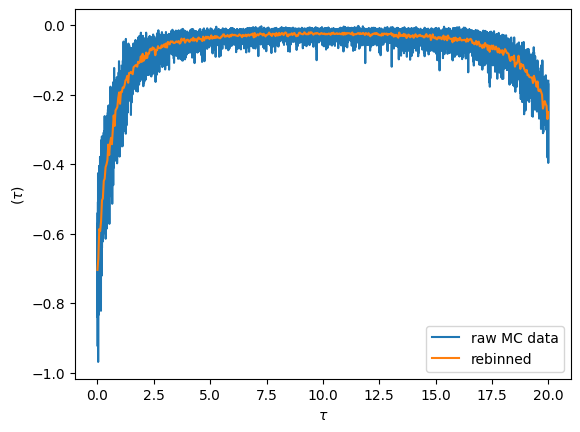

In [3]:
from triqs.plot.mpl_interface import *

oplot(S.G_tau['up'].real, '-', c='C0', label='raw MC data')

G_imp_rebinned = S.G_tau['up'].rebinning_tau(new_n_tau=500)
oplot(G_imp_rebinned.real, '-', c='C1', label='rebinned')

plt.legend(loc='lower right')
plt.show()

Visualizing the Matsubara-frequency results
-------------------------------------------

We can also plot the results on the Matsubara axis and see how our statistics look in terms of the resulting noise. The solver automatically Fourier transforms `S.G_tau` to the Matsubara axis after finishing sampling, and the resulting Green's function can be accessed as `S.G_iw`:

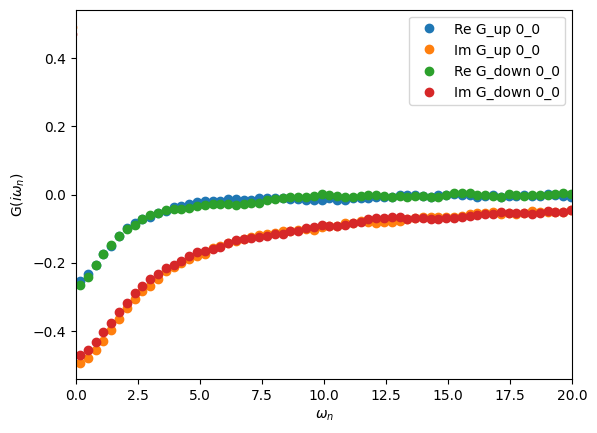

In [4]:
oplot(S.G_iw, 'o')
plt.xlim(0,20)
plt.show()

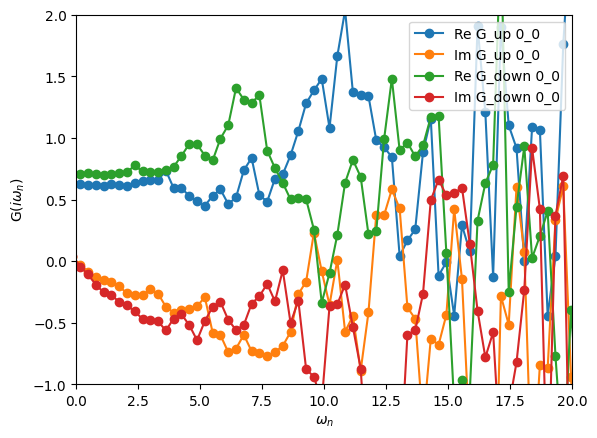

In [5]:
oplot(S.Sigma_iw, '-o')
plt.xlim(0,20)
plt.ylim(-1.0,2.0)
plt.show()

The large oscillations in the self-energy are due to a bad statistics in the Monte Carlo.

<i class="fa fa-gear fa-x" style="color: #186391"></i> Exercise
--------

Increase and decrease the number of Monte Carlo cycles to see its effect on the quality of the self-energy.